In [2]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
%matplotlib inline
from image_helper import *
from parse_xml_annotations import *
from features import *
from reinforcement import *
from metrics import *
import logging
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Load Image

In [3]:
print("load images")
path_voc = "../datas/VOCdevkit/VOC2007"
image_names = np.array(load_images_names_in_data_set('aeroplane_test', path_voc))
labels = load_images_labels_in_data_set('aeroplane_test', path_voc)
image_names_aero = []
for i in range(len(image_names)):
    if labels[i] == '1':
        image_names_aero.append(image_names[i])
image_names = image_names_aero
images = get_all_images(image_names, path_voc)
print("aeroplane_test image:%d" % len(image_names))

load images
aeroplane_test image:204


# load model

In [4]:
Q_NETWORK_PATH = '../models/' + 'voc2012_2007_model'
model = torch.load(Q_NETWORK_PATH)
model_vgg = getVGG_16bn("../models")
model_vgg = model_vgg.cuda()

# get the bounding box annotation by the model's agent

In [78]:
class_object = 1
steps = 10
res = []
res_step = []
res_annotations = []
for i in range(len(image_names)):
    image_name = image_names[i]
    image = images[i]
    
    # get use for iou calculation
    gt_annotation = get_bb_of_gt_from_pascal_xml_annotation(image_name, path_voc)
    original_shape = (image.shape[0], image.shape[1])
    classes_gt_objects = get_ids_objects_from_annotation(gt_annotation)
    gt_masks = generate_bounding_box_from_annotation(gt_annotation, image.shape)
    
    # the initial part
    region_image = image
    size_mask = image.shape
    region_mask = np.ones((image.shape[0], image.shape[1]))
    offset = (0, 0)
    history_vector = torch.zeros((4,6))
    state = get_state(region_image, history_vector, model_vgg)
    done = False
    
    # save the bounding box maked by agent
    annotations = []
    annotation = get_annotation(offset, size_mask)
    annotations.append(annotation)
    
    for step in range(steps):
            # Select action
            qval = model(Variable(state))
            _, predicted = torch.max(qval.data,1)
            action = predicted[0] + 1
            # Perform the action and observe new state
            if action == 6:
                next_state = None
                done = True
            else:
                offset, region_image, size_mask, region_mask = get_crop_image_and_mask(original_shape, offset,
                                                                   region_image, size_mask, action)
               
                #print(offset, size_mask, region_image.shape, region_mask.shape)
                annotation = get_annotation(offset, size_mask)
                annotations.append(annotation)
                history_vector = update_history_vector(history_vector, action)
                next_state = get_state(region_image, history_vector, model_vgg)

            # Move to the next state
            state = next_state
            if done:
                res_step.append(step)
                res_annotations.append((gt_annotation, annotations, image))
                break
                
    iou = find_max_bounding_box(gt_masks, region_mask, classes_gt_objects, class_object)
    pos = 0
    reward = qval.data[0,5]
    if iou > 0.5:
        pos = 1

    res.append((reward, pos))

In [18]:
def draw_bouding_box_1(annotation, img):
    new_img = Image.fromarray(img)
    draw = ImageDraw.Draw(new_img)
    length = len(annotation)
    annotation = np.array(annotation)
    for i in range(length):
        x_min = int(annotation[i,1])
        x_max = int(annotation[i,2])
        y_min = int(annotation[i,3])
        y_max = int(annotation[i,4])
        draw.line(((x_min, y_min), (x_max, y_min)), fill="red", width=3)
        draw.line(((x_min, y_min), (x_min, y_max)), fill="red", width=3)
        draw.line(((x_max, y_min), (x_max, y_max)), fill="red", width=3)
        draw.line(((x_min, y_max), (x_max, y_max)), fill="red", width=3)
    plt.figure()
    plt.imshow(new_img)

def get_annotation(offset, size_mask):
    annotation = np.zeros(5)
    annotation[3] = offset[0]
    annotation[4] = offset[0] + size_mask[0]
    annotation[1] = offset[1]
    annotation[2] = offset[1] + size_mask[1] 
    return annotation

# Show the detection result

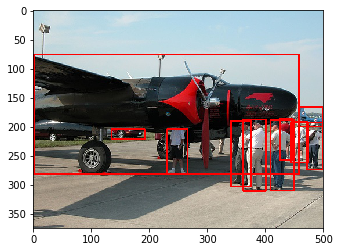

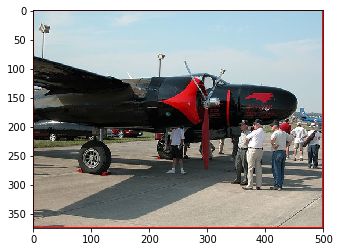

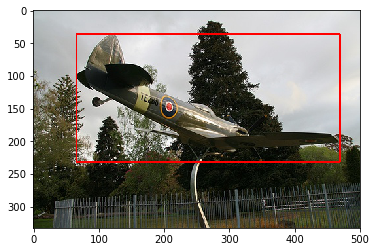

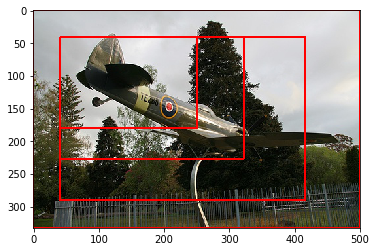

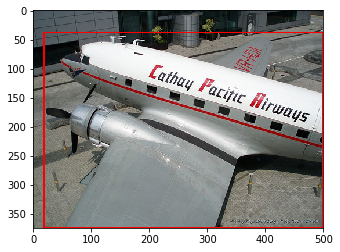

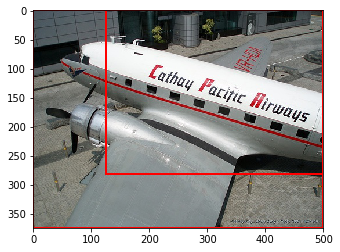

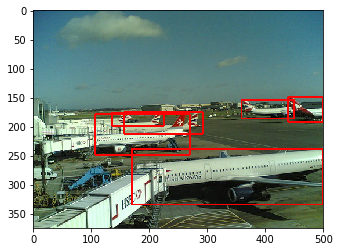

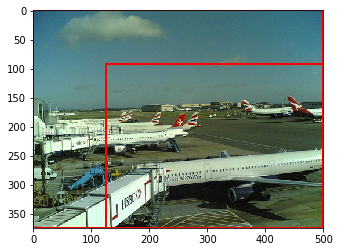

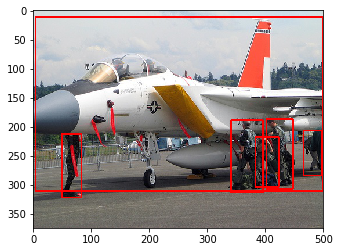

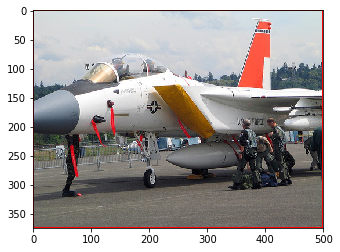

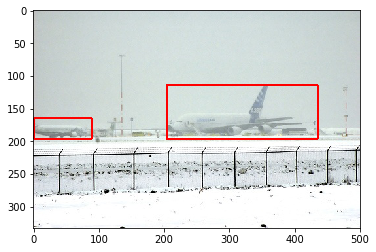

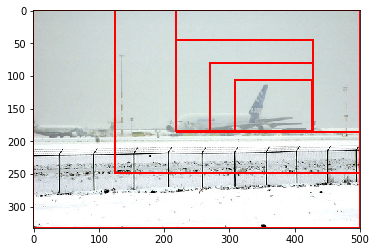

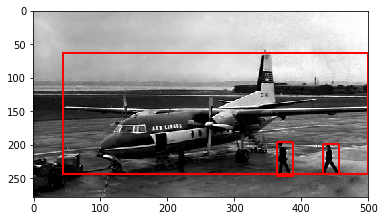

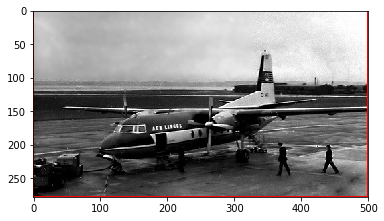

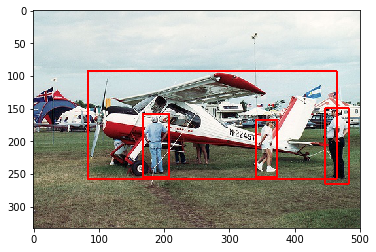

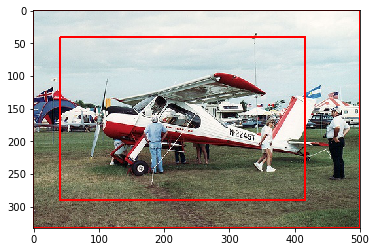

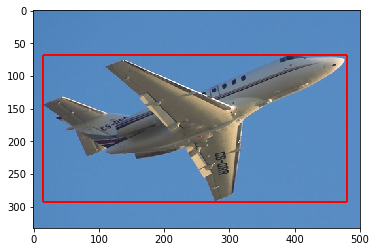

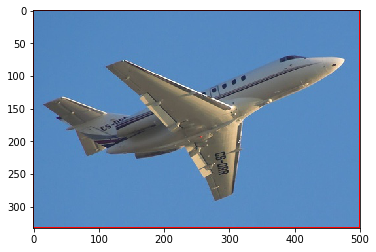

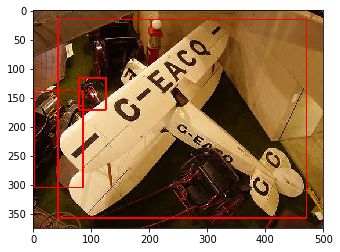

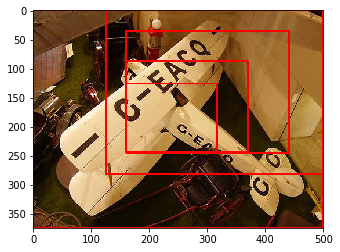

In [77]:
begin = 170
end = begin + 10
for i in range(begin, end):
    gt_annotation, annotation, image = res_annotations[i]
    draw_bouding_box_1(gt_annotation, image)
    draw_bouding_box_1(annotation, image)

# get the PR-Curve and AP

Average precision-recall score: 0.61


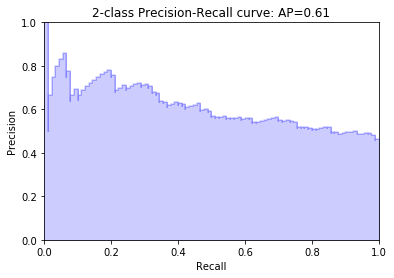

In [24]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
y_test = [x[1] for x in res]
y_score = [x[0] for x in res]
y_test = y_test[::-1]
y_score = y_score[::-1]
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, _ = precision_recall_curve(y_test, y_score)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1])
plt.xlim([0.0, 1])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

# show the Number of reions analyze per object

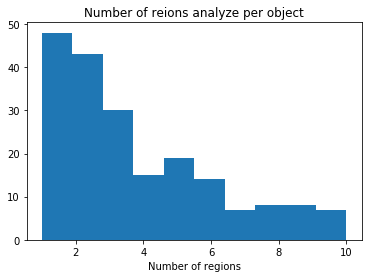

In [79]:
res_step = np.array(res_step) + 1
plt.hist(res_step)
plt.title('Number of reions analyze per object')
plt.xlabel('Number of regions')
